# Assessment 2


 Setup
## Custom install and dataset download

In [1]:
!pip install rdkit torchinfo
!pip install git+https://github.com/bp-kelley/descriptastorus
URL = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv"
!wget -O 'delaney.csv' $URL

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 8.7 MB/s eta 0:00:00
  Cloning https://github.com/bp-kelley/descriptastorus to /tmp/pip-req-build-ad4khgc_
  Running command git clone --filter=blob:none --quiet https://github.com/bp-kelley/descriptastorus /tmp/pip-req-build-ad4khgc_
  Resolved https://github.com/bp-kelley/descriptastorus to commit 9a190343bcd3cfd35142d378d952613bcac40797
  Preparing metadata (setup.py) ... done
  Created wheel for descriptastorus: filename=descriptastorus-2.7.0.3-py3-none-any.whl size=1082893 sha256=90503b62f25c17f5a07bcfd3492cda8ba2a9768ec33db7873e02c59e96d04765
  Stored in directory: /tmp/pip-ephem-wheel-cache-62ktyj2a/wheels/a5/37/b0/bc8b04ad2a1d1f3e17a7bff134d2a7e63621914e0a01d983a6
Successfully built descriptastorus
--2025-04-06 01:28:12--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.192.82, 52.219.121.17

## Import libraries

In [2]:
from pprint import pprint
import IPython.display as ipd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tqdm.auto as tqdm

import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
import rdkit.Chem.Draw
from rdkit.Chem.Draw import IPythonConsole
import descriptastorus.descriptors

import sklearn.model_selection
import sklearn.metrics
import xgboost as xgb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchinfo

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.__version__)

2.6.0+cu124


## Utility functions

In [44]:
def display_header(text, n=2):
  ipd.display(ipd.HTML(f"<h{n}>{text}</h{n}>"))

def cast_tensor(x):
    """Cast tensor to numpy array."""
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    elif isinstance(x, list):
        return np.array(x)
    elif isinstance(x, np.ndarray):
        return x
    else:
        raise ValueError("Input must be torch.Tensor or np.ndarray or list")

def evaluate(y_true, y_pred, extra_info=None):
    """Evaluate regression performance."""
    info = extra_info or {}
    y_true_np = cast_tensor(y_true).ravel()
    y_pred_np = cast_tensor(y_pred).ravel()
    r2 = sklearn.metrics.r2_score(y_true_np, y_pred_np)
    mae = sklearn.metrics.mean_absolute_error(y_true_np, y_pred_np)
    rmse = float(np.sqrt(sklearn.metrics.mean_squared_error(y_true_np, y_pred_np)))
    return info | {'r2': r2, 'mae': mae, 'rmse': rmse}

# Data [1 pt total]

## Dataset Loading

In this section, we will load the Delaney dataset, a widely used dataset in cheminformatics for modeling the solubility of molecules. We will use pandas to load the CSV file and inspect its basic properties.

This is the same task we proposed in the example project early in the class. Understanding the data is the first crucial step in any machine learning project. We'll start by loading the dataset and getting a feel for its structure and content.

In [45]:
SMI_COL = 'smiles'
Y_COL = 'measured log solubility in mols per litre'
df = pd.read_csv('delaney.csv')
print(df.columns)
print(df.shape)
df.head()

Index(['Compound ID', 'ESOL predicted log solubility in mols per litre',
       'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
       'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area',
       'measured log solubility in mols per litre', 'smiles'],
      dtype='object')
(1128, 10)


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


## Dataset splitting

To properly evaluate our models, we need to split the dataset into training, validation, and test sets. This ensures that we can tune our model parameters on the validation set and get an unbiased estimate of performance on the unseen test set. We will use scikit-learn's `train_test_split` for this purpose, ensuring a consistent split using a `random_state`.

In [46]:
index = np.arange(df.shape[0])
train_val_index, test_index = sklearn.model_selection.train_test_split(index, test_size=0.2, random_state=42)
train_index, val_index = sklearn.model_selection.train_test_split(train_val_index, test_size=0.15/0.8, random_state=42)

smi = df[SMI_COL].to_numpy(str)
y = df[Y_COL].to_numpy(float).reshape(-1, 1)

## Feature generators

Machine learning models require numerical input features. For molecules, we can generate different types of features. In this assignment, we will explore two feature representations:

1.  **Baseline 2D descriptors**: These are classical molecular descriptors calculated from the 2D structure of the molecule. We will use `descriptastorus` library to generate these.
2.  **Graph representation**: Representing a molecule as a graph, where atoms are nodes and bonds are edges. This representation is particularly suitable for Graph Neural Networks. We will implement a function to convert SMILES strings to graph tensors.

In [47]:
def smiles_to_baseline_features(smiles_list):
    """Convert SMILES to baseline 2D descriptors."""
    generator = descriptastorus.descriptors.RDKit2DHistogramNormalized()
    values = [generator.process(s)[1:] for s in tqdm.tqdm(smiles_list)]
    return np.stack(values, dtype=np.float32)

def smiles_to_graph(smiles):
    """Converts SMILES string to graph representation with adjacency matrix."""
    mol = rdkit.Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES: {smiles}")

    atom_symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]
    bond_types = [bond.GetBondType() for bond in mol.GetBonds()]
    num_atoms = len(atom_symbols)

    atom_type_vocab = ['C', 'N', 'O', 'S', 'F', 'P', 'Cl', 'Br', 'I', 'H']
    atom_feature_matrix = []
    for symbol in atom_symbols:
        feature = [0] * len(atom_type_vocab)
        if symbol in atom_type_vocab:
            feature[atom_type_vocab.index(symbol)] = 1
        atom_feature_matrix.append(feature)
    node_features = torch.tensor(atom_feature_matrix, dtype=torch.float32)

    adjacency_matrix = np.zeros((num_atoms, num_atoms), dtype=np.float32)
    for bond in mol.GetBonds():
        start_atom_index = bond.GetBeginAtomIdx()
        end_atom_index = bond.GetEndAtomIdx()
        adjacency_matrix[start_atom_index, end_atom_index] = 1.0
        adjacency_matrix[end_atom_index, start_atom_index] = 1.0

    adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32)
    adjacency_matrix = adjacency_matrix + torch.eye(num_atoms, dtype=torch.float32)
    globals_vector = torch.zeros(1, dtype=torch.float32)

    return node_features, adjacency_matrix, globals_vector

## Example Molecule and Graph Tensors

Let's visualize an example molecule from the dataset and see the output of our feature generation functions. We will randomly select a molecule and display its 2D rendering, the graph tensor representation, and the baseline feature vector. This helps to understand the input data formats for our models.

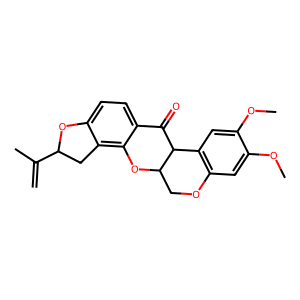

(tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],

  0%|          | 0/1 [00:00<?, ?it/s]

array([[0.3530347 , 0.65324575, 0.5813807 , 0.63189423, 0.5812707 ,
        0.6157231 , 0.6128529 , 0.52440673, 0.6742572 , 0.57165   ,
        0.74813235, 0.6554259 , 0.785275  , 0.6957287 , 0.7302711 ,
        0.34934446, 0.9944496 , 0.7158101 , 0.8642505 , 0.54945844,
        0.24450712, 0.75822306, 0.45655197, 0.22599582, 0.94326603,
        0.57093996, 0.52045643, 0.5684698 , 0.62057346, 0.5452682 ,
        0.3815267 , 0.6967788 , 0.5583091 , 0.99998   , 0.47485325,
        0.2930605 , 0.73850167, 0.5773404 , 0.8395088 , 0.93783957,
        0.8395088 , 0.10527159, 0.18918325, 0.10183379, 0.5482684 ,
        0.24684614, 0.6039123 , 0.5338474 , 0.5702399 , 0.5672897 ,
        0.89862293, 0.8271579 , 0.9981999 , 0.99755985, 0.9762883 ,
        0.9476463 , 0.9929895 , 0.9831488 , 0.5992519 , 0.8791915 ,
        0.99997   , 0.52811694, 0.8704909 , 0.89316255, 0.8413989 ,
        0.6829678 , 0.8789215 , 0.98258877, 0.9735981 , 0.48463392,
        0.5614493 , 0.6346544 , 0.47677338, 0.34

In [48]:
random_index = np.random.choice(df.shape[0])
smiles = smi[random_index]
mol = rdkit.Chem.MolFromSmiles(smiles)
display_header('Molecule rending')
ipd.display(rdkit.Chem.Draw.MolToImage(mol))
one_graph = smiles_to_graph(smiles)
display_header('graph tensor')
pprint(one_graph)
display_header('baseline vector')
data = smiles_to_baseline_features([smiles])
pprint(data)

## Exploratory Data Analysis (EDA) [.5 pt]

**Exercise: EDA on dataset.**

**Goal:** Perform some Exploratory Data Analysis (EDA) on this dataset to understand its characteristics and properties.

**Expected output:** Code and visualizations

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 10 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Compound ID                                      1128 non-null   object 
 1   ESOL predicted log solubility in mols per litre  1128 non-null   float64
 2   Minimum Degree                                   1128 non-null   int64  
 3   Molecular Weight                                 1128 non-null   float64
 4   Number of H-Bond Donors                          1128 non-null   int64  
 5   Number of Rings                                  1128 non-null   int64  
 6   Number of Rotatable Bonds                        1128 non-null   int64  
 7   Polar Surface Area                               1128 non-null   float64
 8   measured log solubility in mols per litre        1128 non-null   float64
 9   smiles                        

,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre
count,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000
mean,-2.988192,1.058511,203.937074,0.701241,1.390957,2.177305,34.872881,-3.050102
std,1.683220,0.238560,102.738077,1.089727,1.318286,2.640974,35.383593,2.096441
min,-9.702000,0.000000,16.043000,0.000000,0.000000,0.000000,0.000000,-11.600000
25%,-3.948250,1.000000,121.183000,0.000000,0.000000,0.000000,0.000000,-4.317500
50%,-2.870000,1.000000,182.179000,0.000000,1.000000,1.000000,26.300000,-2.860000
75%,-1.843750,1.000000,270.372000,1.000000,2.000000,3.000000,55.440000,-1.600000
max,1.091000,2.000000,780.949000,11.000000,8.000000,23.000000,268.680000,1.580000


Missing values:
 Compound ID                                        0
ESOL predicted log solubility in mols per litre    0
Minimum Degree                                     0
Molecular Weight                                   0
Number of H-Bond Donors                            0
Number of Rings                                    0
Number of Rotatable Bonds                          0
Polar Surface Area                                 0
measured log solubility in mols per litre          0
smiles                                             0
dtype: int64


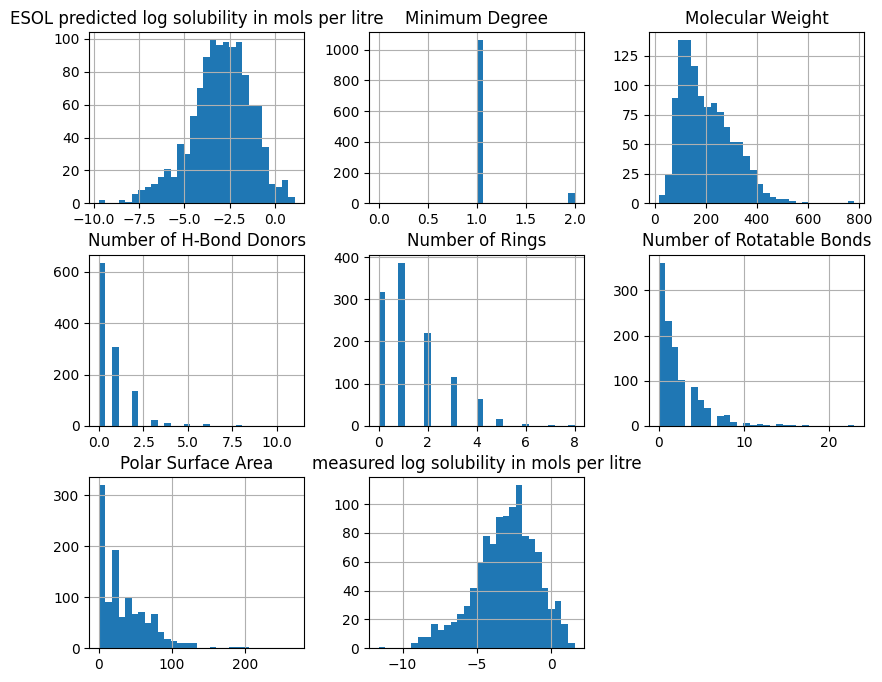

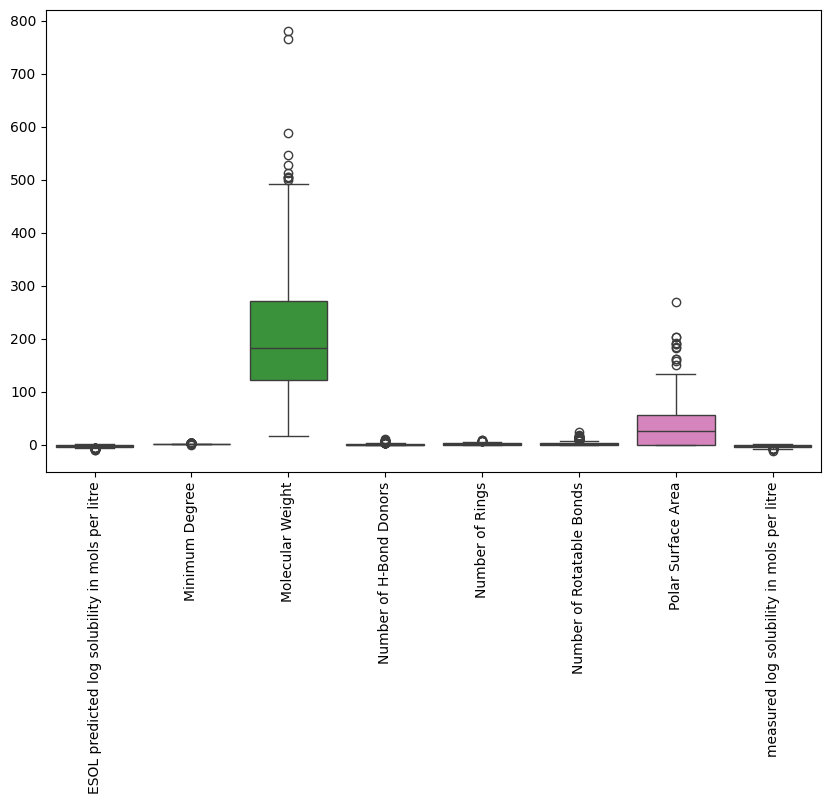

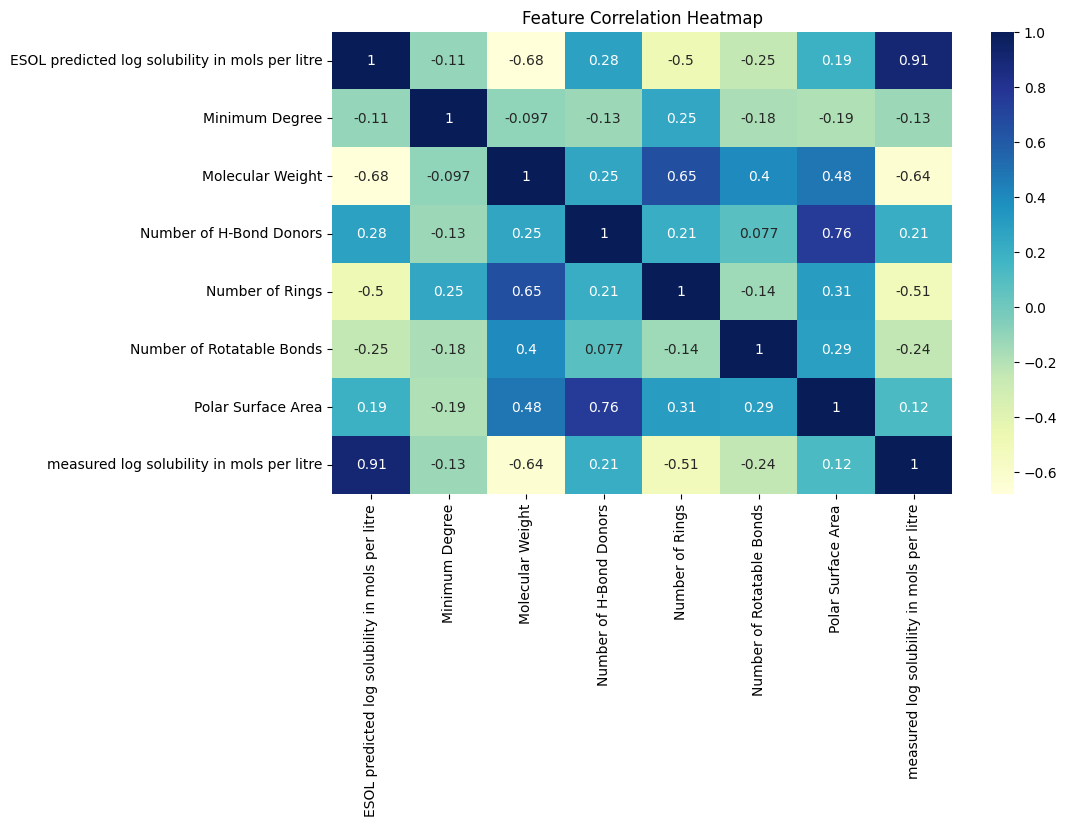

In [49]:
# Explore the data and summary statistics
print(df.info())
display(df.describe())

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Handle missing values
df.isnull().sum()
df.fillna(0, inplace=True)

# Plot data distribution using a histogram
df.hist(figsize=(10,8), bins=30)
plt.show()

# Create a boxplot distribution
plt.figure(figsize=(10,6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

# Drop non-numeric columns before calculating correlation
numerical_df = df.select_dtypes(include=np.number)

# Create correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(numerical_df.corr(), annot=True, cmap="YlGnBu")
plt.title("Feature Correlation Heatmap")
plt.show()

## EDA Reflection [.5 pt]

Explain why you select these figures for the EDA, what do they tell you? What questions are you trying to answer?

**Exercise: Reflect on the purpose of your EDA.**

**Goal:** Explain your choices of EDA techniques and interpret the resulting visualizations in the context of understanding the Delaney solubility dataset and informing your modeling approach. What insights did you gain from the EDA that might be helpful for building effective models?

**Goal:** Reflect on the purpose of your EDA.

**Expected output:** Text.


The purpose of the EDA was to understand the different variables in the Delaney dataset and their role in predicting solubility. To summarize dataset statistics such as mean and standard deviation, I used df.describe(). Since missing values can skew results, I analyzed their distribution and replaced missing values with 0 where appropriate.

To better understand feature distributions, I generated histograms, which revealed that molecular weight is right-skewed while log solubility is left-skewed. Based on this result, I decided that a log transformation may be useful for normalizing data to ensure cohesive results. I also used a boxplot to identify outliers, which might need handling to prevent model bias.

In addition to histograms and boxplots, I created a correlation heatmap, which showed that molecular weight has a strong negative correlation with solubility, while the minimum degree had little impact. These insights will guide feature selection and scaling choices to determine which features are the most important and help me reduce the dimensionality of the data for faster performance.

Overall, the EDA highlighted the need for data transformation, potential feature selection, and handling missing values carefully. These steps ensure the model is trained on well-preprocessed data with minimal bias, leading to better generalization.

# Baselines [.5 pt total]

## XGboost
Before diving into Graph Neural Networks, it's useful to establish a performance baseline using a simpler, non-graph-based model. Here, we will use XGBoost, a powerful gradient boosting algorithm, with the 2D molecular descriptors we generated earlier. This will give us a reference point to compare against our GNN models.

It's always a good practice to start with simpler models to establish a baseline performance. This allows us to understand the complexity of the task and provides a benchmark against which we can measure the improvements offered by more sophisticated models like GNNs. We will use XGBoost, a robust and widely used algorithm, as our baseline.

**Exercise: Implement the XGBoost.**

**Goal:** Implement a baseline for this task.

**Expected output:** Code and Train/val performance metrics.

In [50]:
# Extracting the actual data based on indexes, selecting only numerical features
X_train, X_val, X_test = df.iloc[train_index, 2:].select_dtypes(include=np.number).values, df.iloc[val_index, 2:].select_dtypes(include=np.number).values, df.iloc[test_index, 2:].select_dtypes(include=np.number).values
y_train, y_val, y_test = y[train_index], y[val_index], y[test_index]

# Instantiate XGBoost model, using XGBRegressor for regression
xg_cl = xgb.XGBRegressor(
    objective='reg:squarederror', # Changed objective for regression
    n_estimators=100,
    seed=123,
    early_stopping_rounds=10 # Keep early stopping for regression
)

# Fit the regressor
eval_set = [(X_val, y_val)]
xg_cl.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# Predict for the test set
preds = xg_cl.predict(X_test)

# Evaluate performance (example: R-squared)
from sklearn.metrics import r2_score
r2 = r2_score(y_test, preds)
print(f'R-squared: {r2:.2f}') # Print R-squared

[0]	validation_0-rmse:1.33944
[1]	validation_0-rmse:0.94800
[2]	validation_0-rmse:0.66431
[3]	validation_0-rmse:0.47244
[4]	validation_0-rmse:0.33685
[5]	validation_0-rmse:0.23710
[6]	validation_0-rmse:0.16865
[7]	validation_0-rmse:0.12518
[8]	validation_0-rmse:0.09515
[9]	validation_0-rmse:0.07609
[10]	validation_0-rmse:0.06415
[11]	validation_0-rmse:0.05785
[12]	validation_0-rmse:0.05410
[13]	validation_0-rmse:0.05241
[14]	validation_0-rmse:0.05093
[15]	validation_0-rmse:0.04987
[16]	validation_0-rmse:0.04914
[17]	validation_0-rmse:0.04887
[18]	validation_0-rmse:0.04875
[19]	validation_0-rmse:0.04824
[20]	validation_0-rmse:0.04751
[21]	validation_0-rmse:0.04751
[22]	validation_0-rmse:0.04739
[23]	validation_0-rmse:0.04704
[24]	validation_0-rmse:0.04693
[25]	validation_0-rmse:0.04697
[26]	validation_0-rmse:0.04722
[27]	validation_0-rmse:0.04736
[28]	validation_0-rmse:0.04730
[29]	validation_0-rmse:0.04706
[30]	validation_0-rmse:0.04679
[31]	validation_0-rmse:0.04681
[32]	validation_0-

# Graphs and Graph Neural Network (GNN) [2pt]

## Grraph Dataset and loader definition

To work with graph data in PyTorch, we need to create a custom dataset and dataloader. The `MolGraphDataset` class will handle loading molecules and converting them into graph representations. The `mol_graph_collate_fn` will take care of batching graphs, which involves padding graphs to the same size within a batch for efficient processing.

Graph Neural Networks operate on graph structured data. To feed our molecular graph data into a GNN, we need to define a PyTorch Dataset and DataLoader. This section sets up the data pipeline for training our GNN models.

In [51]:
class MolGraphDataset(torch_data.Dataset):
    """Dataset for molecule graphs."""
    def __init__(self, smiles_list, targets):
        """
        Args:
            smiles_list (list): List of SMILES strings.
            targets (list): List of target values corresponding to each SMILES.
        """
        self.smiles_list = smiles_list
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.smiles_list)

    def __getitem__(self, idx):
        """Returns graph and target for a given index."""
        smiles = self.smiles_list[idx]
        target = self.targets[idx]
        node_features, adjacency_matrix, globals_vector = smiles_to_graph(smiles)
        return (node_features, adjacency_matrix, globals_vector), target

def mol_graph_collate_fn(batch):
    """
    Custom collate function for molecule graphs with padding.
    Args:
        batch (list): List of tuples, where each tuple is ((node_features, adjacency_matrix, globals_vector), target).

    Returns:
        tuple: Padded batched graph data (stacked tensors) and batched targets (tensor).
              Node features and adjacency matrices are padded to the maximum number of nodes in the batch.
    """
    graphs = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    node_features_list = [graph[0] for graph in graphs]
    adjacency_matrix_list = [graph[1] for graph in graphs]
    globals_vector_list = [graph[2] for graph in graphs] # although globals are not used

    # Find max number of nodes in batch
    max_num_nodes = max([nf.size(0) for nf in node_features_list])

    padded_node_features_list = []
    padded_adjacency_matrix_list = []

    for idx, (nf, adj) in enumerate(zip(node_features_list, adjacency_matrix_list)):
        num_nodes = nf.size(0)
        # Node feature padding
        padded_nf = torch.cat([nf, torch.zeros(max_num_nodes - num_nodes, nf.size(1))], dim=0)
        padded_node_features_list.append(padded_nf)

        # Adjacency matrix padding
        padded_adj = torch.cat([adj, torch.zeros(num_nodes, max_num_nodes - num_nodes)], dim=1) # Pad rows
        padded_adj = torch.cat([padded_adj, torch.zeros(max_num_nodes - num_nodes, max_num_nodes)], dim=0) # Pad columns
        padded_adjacency_matrix_list.append(padded_adj)

    # Stack padded features and matrices
    batched_node_features = torch.stack(padded_node_features_list) # Shape: [batch_size, max_num_nodes, node_feature_dim]
    batched_adjacency_matrices = torch.stack(padded_adjacency_matrix_list) # Shape: [batch_size, max_num_nodes, max_num_nodes]
    batched_globals_vectors = torch.stack(globals_vector_list) # Shape: [batch_size, 1, global_feature_dim] # No padding for globals
    batched_targets = torch.stack(targets)
    return (batched_node_features, batched_adjacency_matrices, batched_globals_vectors), batched_targets

## Create Graph datasets and loaders

With the dataset and collate function defined, we can now create the actual datasets for training, validation, and testing. We also create the corresponding data loaders, which will handle batching and shuffling of the data during training. Let's inspect the shape of a sample batch to understand the data format that will be fed into our GNN model.

In [52]:
BATCH_SIZE = 32
train_dataset = MolGraphDataset(smi[train_index], y[train_index])
val_dataset = MolGraphDataset(smi[val_index], y[val_index])
test_dataset = MolGraphDataset(smi[test_index], y[test_index])

train_loader = torch_data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                     shuffle=True, collate_fn=mol_graph_collate_fn )
val_loader = torch_data.DataLoader(val_dataset, batch_size=BATCH_SIZE,
                                    shuffle=False, collate_fn=mol_graph_collate_fn)
test_loader = torch_data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                    shuffle=False, collate_fn=mol_graph_collate_fn)

sample_batch, sample_y = next(iter(train_loader))
node_dim = sample_batch[0].shape[2] # Corrected index to shape[2]
adj_dim = sample_batch[1].shape[2] # Corrected index to shape[2]
global_dim = sample_batch[2].shape[1] # Corrected index to shape[2]
display_header(f'nodes: {sample_batch[0].shape}')
display_header(f'adj: {sample_batch[1].shape}')
display_header(f'globals: {sample_batch[2].shape}')

## Layer definition [.5 pt]

**Exercise: Implement the Graph Convolution Layer**

**Goal:** Translate the mathematical formulation of a Graph Convolution Layer into PyTorch code. Implement the `GraphConvLayer` class based on the following equation for updating node features in a graph convolutional layer:

$$
\mathbf{h}_i^{(l+1)} = \sigma \left( \sum_{j \in \mathcal{N}(i) \cup \{i\}} \mathbf{W}^{(l)} \mathbf{h}_j^{(l)} \right)
$$

Where:
- $\mathbf{h}_i^{(l)}$ is the feature vector of node $i$ in layer $l$.
- $\mathbf{W}^{(l)}$ is the weight matrix for layer $l$.
- $\mathcal{N}(i)$ is the set of neighbors of node $i$.
- $\sigma$ is an activation function.

Implement the `forward` function of the `GraphConvLayer` class to perform this computation. You will need to use matrix multiplication and summation operations in PyTorch.


**Expected output:** Code.

In [53]:
class GraphConvLayer(nn.Module):
    """Simple Graph Convolution Layer."""
    def __init__(self, in_features, out_features):
        """
        Args:
            in_features (int): Number of input node features.
            out_features (int): Number of output node features.
        """
        super().__init__()
        self.projection = nn.Linear(in_features, out_features)
        self.activation = nn.ReLU()

    def forward(self, node_features, adjacency_matrix):
        """
        Args:
            node_features (torch.Tensor): Node feature matrix (B, N, in_features).
            adjacency_matrix (torch.Tensor): Adjacency matrix (B, N, N).
        Returns:
            torch.Tensor: Updated node features (B, N, out_features).
        """

        # Add self-loops (identity matrix)
        identity = torch.eye(adjacency_matrix.size(1), device=adjacency_matrix.device).unsqueeze(0)  # (1, N, N)
        adjacency_matrix = adjacency_matrix + identity

        # Normalize adjacency matrix
        num_neighbours = adjacency_matrix.sum(dim=-1, keepdim=True) + 1e-6

        # Apply linear transformation BEFORE aggregation
        transformed_features = self.projection(node_features)  # (B, N, out_features)

        # Aggregate information from neighbors
        out = torch.bmm(adjacency_matrix, transformed_features)  # (B, N, out_features)

        # Normalize and apply activation
        out = out / num_neighbours
        out = self.activation(out)

        return out

## Model definition [.5 pt]

**Exercise: Implement the Graph Neural Network Model**

**Goal:** Construct a complete Graph Neural Network (GNN) model for regression. Implement the `GNN` class, which utilizes the `GraphConvLayer` you defined earlier. This model should consist of multiple graph convolutional layers followed by a global pooling operation and a final linear layer for regression.

**Expected output:** Code.

In [58]:
class GNN(nn.Module):
    """Simple Graph Network using Graph Convolution for regression."""
    def __init__(self, node_feature_dim, hidden_dim, num_layers):
        """
        Args:
            node_feature_dim (int): Dimension of node features.
            hidden_dim (int): Hidden dimension for GNN layers.
            num_layers (int): Number of Graph Convolution layers.
        """
        super(GNN, self).__init__()

        # First GCN layer
        self.layers = nn.ModuleList([GraphConvLayer(node_feature_dim, hidden_dim)])

        # Additional GCN layers
        for _ in range(num_layers - 1):
            self.layers.append(GraphConvLayer(hidden_dim, hidden_dim))

        # Final linear layer for regression
        self.fc = nn.Linear(hidden_dim + 1, 1)

        # Add activation function
        self.relu = nn.ReLU()

    def forward(self, batched_node_features, batched_adjacency_matrices, batched_globals_vectors):
        """
        Args:
            batched_node_features (torch.Tensor): Batched node feature matrix (B, N, node_feature_dim).
            batched_adjacency_matrices (torch.Tensor): Batched adjacency matrix (B, N, N).
            batched_globals_vectors (torch.Tensor): Batched global vectors (B, 1, global_feature_dim).
        Returns:
            torch.Tensor: Predicted solubility value. (B, 1)
        """
        hidden = batched_node_features

        # Apply multiple GCN layers
        for layer in self.layers:
            hidden = layer(hidden, batched_adjacency_matrices)
            hidden = self.relu(hidden)

        # Implement mean pooling over nodes
        graph_representation = hidden.mean(dim=1)

        # Final regression prediction
        batched_globals_vectors = batched_globals_vectors.squeeze(1).unsqueeze(-1)
        combined_representation = torch.cat((graph_representation, batched_globals_vectors), dim=-1)
        prediction = self.fc(combined_representation)

        return prediction

## Instanciate a model

This snippet should work if your model definition is correct. We will instantiate the `GNN` model and print a summary of the model architecture and parameters using `torchinfo`. This is a useful step to verify that our model is defined as intended before training.

**Goal:** Instantiate the GNN model and verify its structure.

**Expected output:** Code to instantiate the GNN model and the model summary output from `torchinfo`.

In [59]:
model_gnn = GNN(node_feature_dim=10, hidden_dim=32, num_layers=3)
print(torchinfo.summary(model_gnn, input_data=sample_batch))

Layer (type:depth-idx)                   Output Shape              Param #
GNN                                      [32, 1]                   --
├─ModuleList: 1-5                        --                        (recursive)
│    └─GraphConvLayer: 2-1               [32, 31, 32]              --
│    │    └─Linear: 3-1                  [32, 31, 32]              352
│    │    └─ReLU: 3-2                    [32, 31, 32]              --
├─ReLU: 1-2                              [32, 31, 32]              --
├─ModuleList: 1-5                        --                        (recursive)
│    └─GraphConvLayer: 2-2               [32, 31, 32]              --
│    │    └─Linear: 3-3                  [32, 31, 32]              1,056
│    │    └─ReLU: 3-4                    [32, 31, 32]              --
├─ReLU: 1-4                              [32, 31, 32]              --
├─ModuleList: 1-5                        --                        (recursive)
│    └─GraphConvLayer: 2-3               [32, 31, 32] 

## Basic training/evaluation

Do not modify this code, use as is.

In [15]:
def evaluate_model(model, data_loader, criterion, info):
    """Evaluates the model on the given dataloader."""
    model.eval()
    all_predictions = []
    all_targets = []
    total_loss = 0.0  # Initialize total_loss
    with torch.no_grad():
        for (batch_graphs, batch_targets) in data_loader:
            batched_node_features, batched_adjacency_matrices, batched_globals_vectors = batch_graphs
            batch_predictions = model(batched_node_features, batched_adjacency_matrices, batched_globals_vectors)
            loss = criterion(batch_predictions, batch_targets) # Calculate loss for this batch
            total_loss += loss.item() * len(batch_targets) # Accumulate batch loss
            all_predictions.extend(batch_predictions.tolist())
            all_targets.extend(batch_targets.tolist())

    avg_loss = total_loss / len(data_loader.dataset) # Calculate average loss over dataset
    extra_info = info | {'loss': avg_loss} # Use average loss in info
    return evaluate(all_targets, all_predictions, extra_info)

In [16]:
def train_loop(model, train_loader, val_loader, epochs, learning_rate, base_info):
    """Simple training loop with evaluation."""
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    history = []
    pbar = tqdm.tqdm(range(epochs), desc="Epochs")
    for epoch in pbar:
        model.train()
        train_loss = 0.0
        for (batch_graphs, batch_targets) in train_loader:
            batched_node_features, batched_adjacency_matrices, batched_globals_vectors = batch_graphs
            optimizer.zero_grad()
            batch_predictions = model(batched_node_features, batched_adjacency_matrices, batched_globals_vectors)
            loss = criterion(batch_predictions, batch_targets)
            loss.backward()
            optimizer.step()

        info = base_info | {'epoch': epoch+1}
        train_metrics = evaluate_model(model, train_loader, criterion, info | {'Split':'Train'})
        val_metrics = evaluate_model(model, val_loader, criterion, info | {'Split':'Val'})
        history.extend([train_metrics, val_metrics])
        pbar.set_postfix(val_metrics)
    return history


## Train a GNN [.25 pt]

**Exercise: Train your GNN model**

**Goal:** Train the GNN model you have implemented. Use the provided training loop and evaluate the model on the validation set after each epoch. Monitor the training progress by observing the performance metrics.

**Expected output:** Python code to train the GNN model. A table showing the training and validation metrics for each epoch.

In [60]:
# Training configuration
EPOCHS = 50
LR = 0.001
base_info = {'model_type': 'GNN'}

# Train the model and collect training history
history = train_loop(
    model=model_gnn,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    learning_rate=LR,
    base_info=base_info
)

# Convert history to a DataFrame for easy analysis
history_df = pd.DataFrame(history)

# Display training and validation metrics as a table
table_df = history_df[['epoch', 'Split', 'loss', 'r2', 'mae', 'rmse']].round(4)
print(table_df.to_string(index=False))  # Print table-friendly format

# Evaluate on the test set
test_metrics = evaluate_model(model_gnn, test_loader, nn.MSELoss(), {'Split': 'Test'})
print("\nFinal Test Metrics:", test_metrics)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

 epoch Split    loss      r2    mae   rmse
     1 Train 13.8005 -2.0784 3.1261 3.7149
     1   Val 12.5923 -2.5502 3.0751 3.5486
     2 Train 12.4454 -1.7761 2.9286 3.5278
     2   Val 11.2520 -2.1723 2.8739 3.3544
     3 Train  9.5027 -1.1197 2.4729 3.0826
     3   Val  8.3354 -1.3500 2.3958 2.8871
     4 Train  4.9014 -0.0933 1.6924 2.2139
     4   Val  3.8341 -0.0809 1.5461 1.9581
     5 Train  3.8828  0.1339 1.5704 1.9705
     5   Val  3.2306  0.0892 1.4459 1.7974
     6 Train  3.5544  0.2072 1.4651 1.8853
     6   Val  2.7896  0.2135 1.3417 1.6702
     7 Train  3.3759  0.2470 1.4341 1.8374
     7   Val  2.6671  0.2481 1.3144 1.6331
     8 Train  3.1685  0.2932 1.4044 1.7800
     8   Val  2.5610  0.2780 1.2912 1.6003
     9 Train  3.0199  0.3264 1.3581 1.7378
     9   Val  2.4123  0.3199 1.2541 1.5531
    10 Train  2.9145  0.3499 1.3387 1.7072
    10   Val  2.3378  0.3409 1.2336 1.5290
    11 Train  2.6977  0.3982 1.3003 1.6425
    11   Val  2.1929  0.3817 1.1961 1.4808
    12 Trai

## Visualize training performance [.25 pt]

**Goal:** Visualize the training and validation performance of your GNN model over epochs. Plot for both training and validation sets to analyze the learning curves and identify trends in model performance.

**Expected output:** Figures showcasing the model performance across training epochs. These plots should clearly indicate the training and validation curves for each metric.

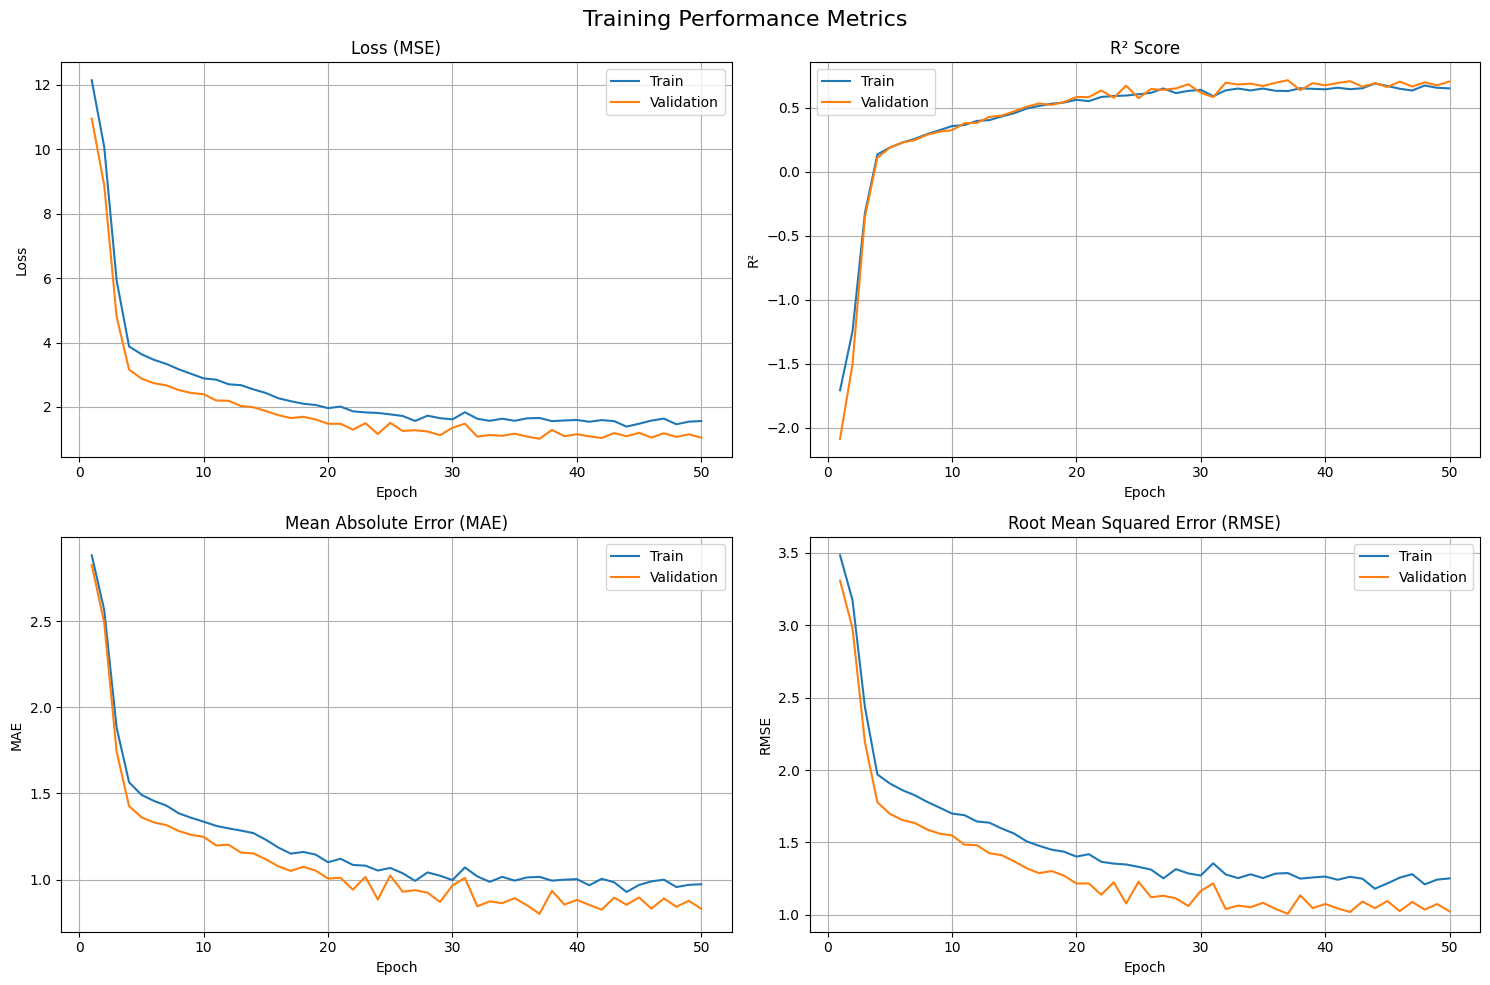

In [18]:
# Convert history to DataFrame
history_df = pd.DataFrame(history)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training Performance Metrics', fontsize=16)

# Plot loss Curve
axes[0,0].plot(history_df[history_df['Split']=='Train']['epoch'],
               history_df[history_df['Split']=='Train']['loss'],
               label='Train')
axes[0,0].plot(history_df[history_df['Split']=='Val']['epoch'],
               history_df[history_df['Split']=='Val']['loss'],
               label='Validation')
axes[0,0].set_title('Loss (MSE)')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()
axes[0,0].grid(True)

# Plot R² Score
axes[0,1].plot(history_df[history_df['Split']=='Train']['epoch'],
               history_df[history_df['Split']=='Train']['r2'],
               label='Train')
axes[0,1].plot(history_df[history_df['Split']=='Val']['epoch'],
               history_df[history_df['Split']=='Val']['r2'],
               label='Validation')
axes[0,1].set_title('R² Score')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('R²')
axes[0,1].legend()
axes[0,1].grid(True)

# Plot MAE
axes[1,0].plot(history_df[history_df['Split']=='Train']['epoch'],
               history_df[history_df['Split']=='Train']['mae'],
               label='Train')
axes[1,0].plot(history_df[history_df['Split']=='Val']['epoch'],
               history_df[history_df['Split']=='Val']['mae'],
               label='Validation')
axes[1,0].set_title('Mean Absolute Error (MAE)')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('MAE')
axes[1,0].legend()
axes[1,0].grid(True)

# Plot RMSE
axes[1,1].plot(history_df[history_df['Split']=='Train']['epoch'],
               history_df[history_df['Split']=='Train']['rmse'],
               label='Train')
axes[1,1].plot(history_df[history_df['Split']=='Val']['epoch'],
               history_df[history_df['Split']=='Val']['rmse'],
               label='Validation')
axes[1,1].set_title('Root Mean Squared Error (RMSE)')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('RMSE')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

## Reflection on GNNs [.5 pt]


**Exercise: Reflect on your GNN training experience**

**Goal:** Compare and contrast the process of training a GNN with training other types of neural networks or machine learning models you have encountered previously.

Consider aspects such as:

* Are the chosen node and edge features sufficient for solubility prediction?

* What are the limitations of the graph convolution layer you implemented? How could different message passing or aggregation mechanisms within the layer improve learning?

* How does your GCN relate to more general Graph Neural Network concepts?

* What other GNN architectures might be more effective for this task, and why?

* If you were to improve your GCN, what are the top three specific changes you would try, and why?

**Expected output:** A written reflection summarizing your observations and insights on training GNNs.

The process of training a GNN is different from training other types of neural networks as it requires the data to be structured as graphs.

The chosen nodes and edge features were sufficient to give the model a strong foundation for learning, but the lack of edge features like bond types or bond order might limit the model’s expressiveness. Incorporating such edge-level information could provide more context during message passing and improve solubility prediction.

Some limitations of graph convolution layer is that it is more likely to experience overfitting because of local message passing where each node only recieves information from their neighbor and misses other nodes. Another limitation is that GCN are computationally expensive due to the graph structure especially for larger datasets.

My GCN implementation is the same as GNNs and message passing where node features are updated based on their neighbors. However, it represents a basic version that lacks flexibility in aggregation and update strategies found in more advanced GNN models

Some GNN architecture that would be effective for this task include graph attention networks and graph transformers. Since the data analysis revealed that certain variables have a larger impact on the solutibility than others, we can assign higher weights to those variables and improve the prediction using graph attention networks. Similarly, graph transformers can combine the graph structure with the global context of transformer models for more meaningful and insightful connections.

To improve the GCN in the future I would add edge features to add depth to the message-passing process and provide more context to the model. I would also GATs for their attention-based aggregation to help the model focus on the most relevant neighbors. Lastly, I will use a global pooling mechanisms that aggregate node information in a more expressive way, helping the model make stronger graph-level predictions.



# Transformer models [2.5 pt]

## Layer definition [1 pt]
**Exercise: Implement Self-Attention Layers**

**Goal:** Implement the core components of a Self-Attention mechanism within a graph context. You will implement the `SelfAttentionLayer`, `FFNLayer`, and `SelfAttentionBlock` classes.

**Self-Attention Layer:**

Implement the `SelfAttentionLayer` class based on the following equations:

$$
\mathbf{Q} = \mathbf{H} \mathbf{W}_Q, \quad \mathbf{K} = \mathbf{H} \mathbf{W}_K, \quad \mathbf{V} = \mathbf{H} \mathbf{W}_V
$$
$$
\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{softmax}\left(\frac{\mathbf{Q}\mathbf{K}^T}{\sqrt{d_k}} \odot \mathbf{M}\right)\mathbf{V}
$$

Where:
- $\mathbf{H}$ is the input node feature matrix.
- $\mathbf{W}_Q, \mathbf{W}_K, \mathbf{W}_V$ are weight matrices for Query, Key, and Value projections.
- $\mathbf{Q}, \mathbf{K}, \mathbf{V}$ are Query, Key, and Value matrices.
- $d_k$ is the dimension of the keys (hidden dimension).
- $\mathbf{M}$ is the attention mask (derived from the adjacency matrix in our case).

**FFN Layer:**

Implement the `FFNLayer` as a simple feed-forward network with ReLU activation:

$$
\text{FFN}(\mathbf{x}) = \text{ReLU}(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2
$$

**Self-Attention Block:**

Combine the `SelfAttentionLayer` and `FFNLayer` in the `SelfAttentionBlock` with layer normalization and residual connections.

**Expected output:** Python code for the `SelfAttentionLayer`, `FFNLayer`, and `SelfAttentionBlock` classes. Ensure that the `forward` methods correctly implement the described equations.

In [62]:
class SelfAttentionLayer(nn.Module):
    """Self Attention Layer."""
    def __init__(self, hidden_dim):
        """
        Args:
            hidden_dim (int): Dimension of hidden features.
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, batched_node_features, batched_adjacency_matrices):
        """
        Args:
            batched_node_features (torch.Tensor): Batched node features (B, N, hidden_dim)
            batched_adjacency_matrices (torch.Tensor): Batched adjacency matrices (B, N, N)

        Returns:
            torch.Tensor: Updated node features with self-attention (B, N, hidden_dim)
        """
        Q = self.query(batched_node_features)
        K = self.key(batched_node_features)
        V = self.value(batched_node_features)

        #d_k = self.hidden_dim ** 0.5  # Scaling factor
        d_k = self.query.out_features ** 0.5
        attn_scores = (Q @ K.transpose(-2, -1)) / d_k  # Compute QK^T / sqrt(d_k)

        # Apply adjacency mask
        attn_scores = attn_scores.masked_fill(batched_adjacency_matrices == 0, float('-1e9'))
        attn_weights = F.softmax(attn_scores, dim=-1)  # Apply softmax
        attn_weights = torch.nan_to_num(attn_weights, nan=0.0)
        attn_weights = self.dropout(attn_weights)
        attn_output = attn_weights @ V  # Multiply by Values

        return attn_output

class FFNLayer(nn.Module):
    """Feed Forward Network Layer."""
    def __init__(self, hidden_dim, ffn_dim):
        """
        Args:
            hidden_dim (int): Hidden dimension.
            ffn_dim (int): Feed-forward network intermediate dimension.
        """
        super().__init__()
        self.fc1 = nn.Linear(hidden_dim, ffn_dim)  # First Linear Layer
        self.fc2 = nn.Linear(ffn_dim, hidden_dim)  # Second Linear Layer
        self.activation = nn.ReLU()  # Activation Function
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        """Forward pass of FFN."""
        # Linear function
        x = self.fc1(x)

        # Non-linearity
        x = self.activation(x)
        x = self.dropout(x)

        # Linear function (readout)
        x = self.fc2(x)
        out = x

        return out

class SelfAttentionBlock(nn.Module):
    """Self Attention Block with Post-Processing."""
    def __init__(self, hidden_dim, ffn_dim):
        """
        Args:
            hidden_dim (int): Hidden dimension.
            ffn_dim (int): Feed-forward network intermediate dimension.
        """
        super(SelfAttentionBlock, self).__init__()
        self.attention = SelfAttentionLayer(hidden_dim)
        self.ffn = FFNLayer(hidden_dim, ffn_dim)

        # Layer Normalization
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)

    def forward(self, batched_node_features, batched_adjacency_matrices):
        """
        Args:
            batched_node_features (torch.Tensor): Batched node features (B, N, hidden_dim).
            batched_adjacency_matrices (torch.Tensor): Batched adjacency matrices (B, N, N).
        Returns:
            torch.Tensor: Processed node features after attention and FFN.
        """
        # Self-Attention with Residual Connection
        attn_out = self.attention(batched_node_features, batched_adjacency_matrices)
        attn_out = self.norm1(attn_out + batched_node_features)  # Residual Connection

        # Feed-Forward Network with Residual Connection
        ffn_out = self.ffn(attn_out)
        norm_output = self.norm2(ffn_out + attn_out)  # Residual Connection

        return norm_output


## Model definition [.5 pt]

**Exercise: Implement the Graph Transformer Model**

**Goal:** Construct a Graph Transformer model for regression. Implement the `GraphTransformer` class, which uses the `SelfAttentionBlock` you just defined. The model should embed the input node features and then pass them through multiple self-attention blocks. Finally, use a aggregation operation and a linear layer for regression.

**Expected output:** Python code for the `GraphTransformer` model class. The model should be designed to process batched graph data and produce solubility predictions.

In [63]:
class GraphTransformer(nn.Module):
    """Transformer with graph features."""
    def __init__(self, node_feature_dim, hidden_dim, num_layers, ffn_dim):
        """
        Args:
            node_feature_dim (int): Dimension of node features.
            hidden_dim (int): Hidden dimension for attention layers.
            num_layers (int): Number of Self-Attention blocks.
            ffn_dim (int): Feed-forward network intermediate dimension.
        """
        super(GraphTransformer, self).__init__()

        # Input embedding layer
        self.embedding = nn.Linear(node_feature_dim, hidden_dim)

        # Stack of Self-Attention Blocks
        self.layers = nn.ModuleList([
            SelfAttentionBlock(hidden_dim, ffn_dim) for _ in range(num_layers)
        ])

        # Aggregation layer (mean pooling)
        self.attn_pool = nn.Linear(hidden_dim, 1)

        # Regression head
        self.regression_head = nn.Linear(hidden_dim, 1)


    def forward(self, batched_node_features, batched_adjacency_matrices, batched_globals_vectors):
        """
        Args:
            batched_node_features (torch.Tensor): Batched node feature matrix (B, N, node_feature_dim).
            batched_adjacency_matrices (torch.Tensor): Batched adjacency matrix (B, N, N).
            batched_globals_vectors (torch.Tensor): Batched global vectors (B, 1, global_feature_dim).
        Returns:
            torch.Tensor: Predicted solubility value.
        """

        # Project node features to hidden space
        x = self.embedding(batched_node_features)

        # Apply Self-Attention Blocks
        for layer in self.layers:
            x = layer(x, batched_adjacency_matrices)

        # Aggregate node features (mean pooling)
        attn_weights = torch.softmax(self.attn_pool(x), dim=1)  # (B, N, 1)
        x = (x * attn_weights).sum(dim=1)  # (B, hidden_dim)

        # Predict solubility
        prediction = self.regression_head(x)

        return prediction

## Instantiate the model

**Goal:** Instantiate the Graph Transformer model and check its architecture.

**Expected output:** Code to instantiate the `GraphTransformer` model, and the model summary from `torchinfo`.

In [64]:
model_attn = GraphTransformer(node_feature_dim = 10, hidden_dim = 128, num_layers = 4, ffn_dim = 512).to(DEVICE)

print(torchinfo.summary(model_attn, input_data=sample_batch))

Layer (type:depth-idx)                   Output Shape              Param #
GraphTransformer                         [32, 1]                   --
├─Linear: 1-1                            [32, 31, 128]             1,408
├─ModuleList: 1-2                        --                        --
│    └─SelfAttentionBlock: 2-1           [32, 31, 128]             --
│    │    └─SelfAttentionLayer: 3-1      [32, 31, 128]             49,536
│    │    └─LayerNorm: 3-2               [32, 31, 128]             256
│    │    └─FFNLayer: 3-3                [32, 31, 128]             131,712
│    │    └─LayerNorm: 3-4               [32, 31, 128]             256
│    └─SelfAttentionBlock: 2-2           [32, 31, 128]             --
│    │    └─SelfAttentionLayer: 3-5      [32, 31, 128]             49,536
│    │    └─LayerNorm: 3-6               [32, 31, 128]             256
│    │    └─FFNLayer: 3-7                [32, 31, 128]             131,712
│    │    └─LayerNorm: 3-8               [32, 31, 128]       

## Train model [.25 pt]

**Exercise: Train the Graph Transformer model**

**Goal:** Train the Graph Transformer model using the provided training loop. Evaluate its performance on the validation set after each epoch and track the training progress using performance metrics.

**Expected output:** Python code to train the Graph Transformer model. A table displaying the training and validation metrics over epochs.

In [65]:
# Training configuration
EPOCHS = 50
LR = 1e-5
base_info = {'model_type': 'GraphTransformer'}

# Train with your existing data loaders
history = train_loop(
    model=model_attn,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    learning_rate=LR,
    base_info=base_info
)

# Convert history to DataFrame for analysis
history_df = pd.DataFrame(history)

# Display training and validation metrics as a table
table_df = history_df[['epoch', 'Split', 'loss', 'r2', 'mae', 'rmse']].round(4)
print(table_df.to_string(index=False))  # Print table-friendly format

# Evaluate on the test set
test_metrics = evaluate_model(model_attn, test_loader, nn.MSELoss(), {'Split': 'Test'})
print("\nFinal Test Metrics:", test_metrics)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

 epoch Split   loss      r2    mae   rmse
     1 Train 5.9572 -0.3288 1.8823 2.4407
     1   Val 4.9532 -0.3965 1.7792 2.2256
     2 Train 4.7866 -0.0677 1.7146 2.1878
     2   Val 3.8142 -0.0754 1.5687 1.9530
     3 Train 4.5294 -0.0103 1.6805 2.1282
     3   Val 3.5993 -0.0148 1.5132 1.8972
     4 Train 4.2920  0.0426 1.6294 2.0717
     4   Val 3.3998  0.0415 1.4714 1.8439
     5 Train 4.0848  0.0888 1.5848 2.0211
     5   Val 3.2121  0.0944 1.4303 1.7922
     6 Train 3.8173  0.1485 1.5180 1.9538
     6   Val 2.9906  0.1569 1.3835 1.7293
     7 Train 3.5230  0.2141 1.4499 1.8770
     7   Val 2.7771  0.2171 1.3338 1.6665
     8 Train 3.2873  0.2667 1.3929 1.8131
     8   Val 2.5663  0.2765 1.2837 1.6020
     9 Train 3.0200  0.3264 1.3390 1.7378
     9   Val 2.3823  0.3283 1.2364 1.5435
    10 Train 2.7897  0.3777 1.2910 1.6702
    10   Val 2.1613  0.3907 1.1782 1.4701
    11 Train 2.6224  0.4150 1.2640 1.6194
    11   Val 2.1256  0.4007 1.1716 1.4579
    12 Train 2.3592  0.4737 1.1951

## Training performance [.25 pt]

**Goal:** Visualize the training process of the Graph Transformer. Plot the training and validation loss metrics across epochs to visualize the learning curves and assess the model's training behavior.

**Expected output:** Figures showing the training and validation performance metrics for the Graph Transformer over epochs.

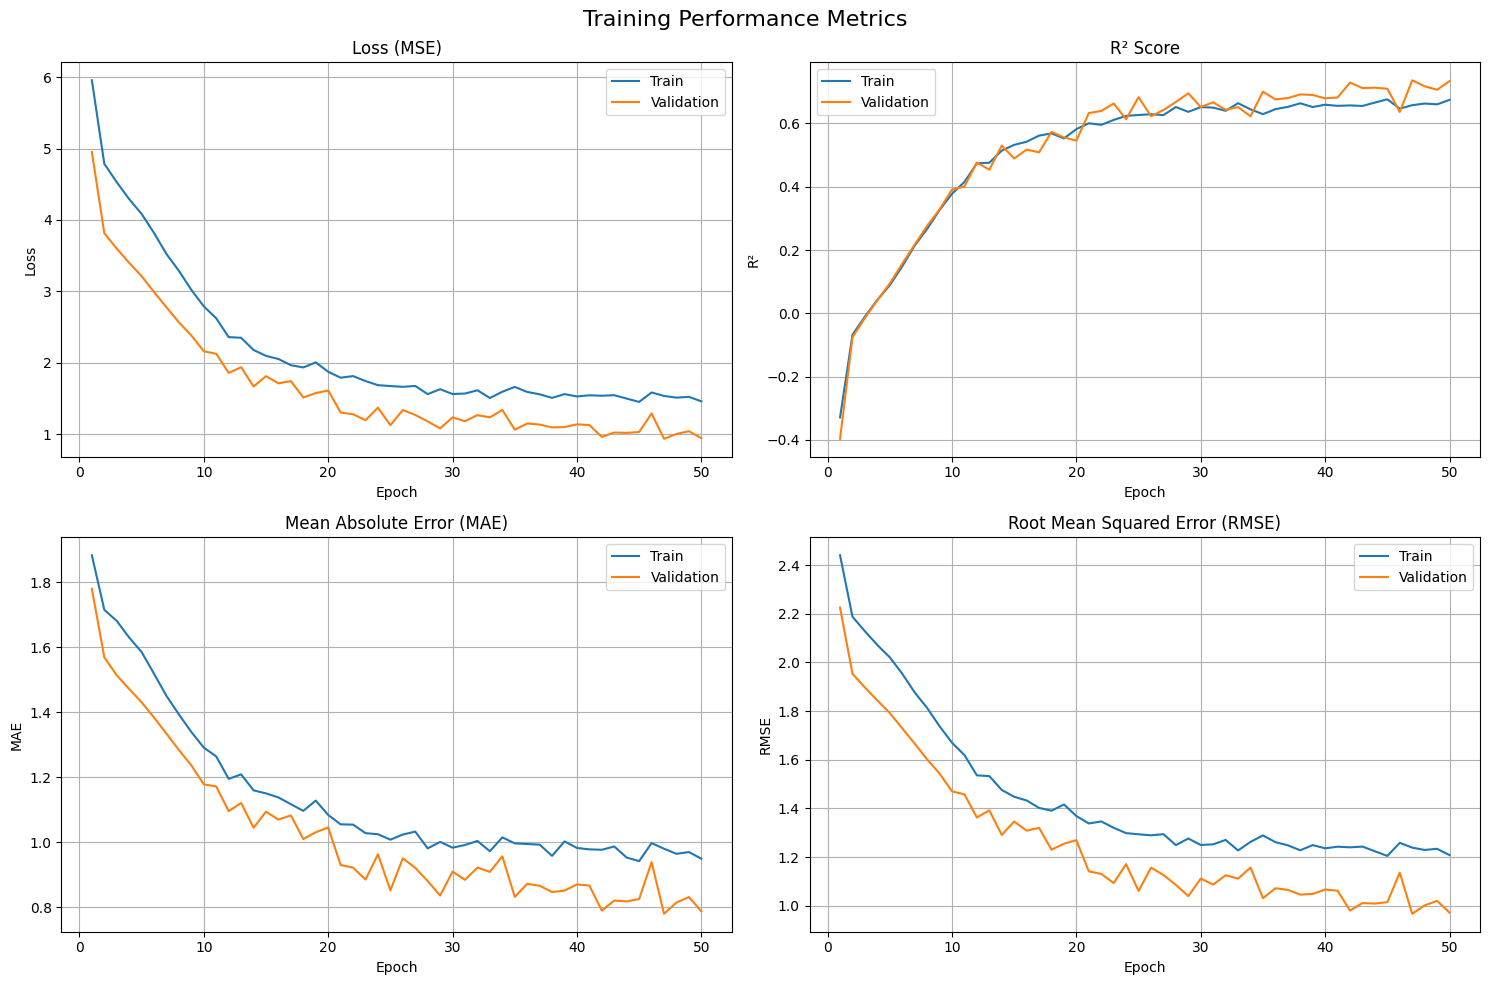

In [66]:
# Convert history to DataFrame
history_df = pd.DataFrame(history)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training Performance Metrics', fontsize=16)

# Plot loss Curve
axes[0,0].plot(history_df[history_df['Split']=='Train']['epoch'],
               history_df[history_df['Split']=='Train']['loss'],
               label='Train')
axes[0,0].plot(history_df[history_df['Split']=='Val']['epoch'],
               history_df[history_df['Split']=='Val']['loss'],
               label='Validation')
axes[0,0].set_title('Loss (MSE)')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()
axes[0,0].grid(True)

# Plot R² Score
axes[0,1].plot(history_df[history_df['Split']=='Train']['epoch'],
               history_df[history_df['Split']=='Train']['r2'],
               label='Train')
axes[0,1].plot(history_df[history_df['Split']=='Val']['epoch'],
               history_df[history_df['Split']=='Val']['r2'],
               label='Validation')
axes[0,1].set_title('R² Score')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('R²')
axes[0,1].legend()
axes[0,1].grid(True)

# Plot MAE
axes[1,0].plot(history_df[history_df['Split']=='Train']['epoch'],
               history_df[history_df['Split']=='Train']['mae'],
               label='Train')
axes[1,0].plot(history_df[history_df['Split']=='Val']['epoch'],
               history_df[history_df['Split']=='Val']['mae'],
               label='Validation')
axes[1,0].set_title('Mean Absolute Error (MAE)')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('MAE')
axes[1,0].legend()
axes[1,0].grid(True)

# Plot RMSE
axes[1,1].plot(history_df[history_df['Split']=='Train']['epoch'],
               history_df[history_df['Split']=='Train']['rmse'],
               label='Train')
axes[1,1].plot(history_df[history_df['Split']=='Val']['epoch'],
               history_df[history_df['Split']=='Val']['rmse'],
               label='Validation')
axes[1,1].set_title('Root Mean Squared Error (RMSE)')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('RMSE')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

## Reflection [.5 pt]

**Exercise: Reflect on Graph Transformer Training**

**Goal:** Compare the training and performance characteristics of the Graph Transformer to the GNN model.

Consider:

*   **GNNs vs. Transformers for Graphs:**
    *   What are the key architectural *similarities* and *differences* between the Graph Transformer and the GNN you implemented?
    *   In what ways might the self-attention mechanism in the Transformer offer advantages or disadvantages compared to the convolution-based message passing in the GNN for graph data?

*   **Adapting to Text Processing:**
    *   How would you need to *modify* the Graph Transformer architecture to process sequential text data instead of graphs? What would represent the "nodes" and "edges" in a text processing Transformer?
    *   What aspects of the self-attention mechanism make it well-suited for both graph and text data?

*   **Computational & Parameter Comparison:**
    *   How does the number of parameters in your Graph Transformer model likely compare to the GNN model with similar hidden dimensions and layers?
    *   Based on your training experience, did you notice any differences in training speed or computational resource usage between the Graph Transformer and the GNN? If so, why might these differences exist?




**Expected output:** Written reflection comparing the GNN and Graph Transformer models, focusing on their training and performance.

In terms of similarities, both GNNs and Graph Transformers operate on graph representation of the data. They both use node features and adjacency information to learn representations. Both models also iteratively update node representations using multiple layers. However, GNNs focus on local context using message passing. In contrast, Graph Transformers use global context through self-attention mechanisms. Another difference is that GNNs rely on predefined or learned rules for neighbor aggregation. In contrast, Graph Transformers allow nodes to attend to all other nodes, modulating attention weights based on the structure of the graph. This adds more flexibility but also increases the computational complexity. The self-attention mechanism used in GNNs is very advantageous compared to convolution-based message passing because it captures long-range interactions that might be missed by the local aggregation. However, one disadvantage of self-attention is that it is computationally expensive, especially for large graphs, as it scales quadratically with the number of nodes, while message passing in GNNs is more efficient and scales linearly. Thus, while the self-attention mechanism enhances the flexibility of the Graph Transformer, it can be more resource-intensive compared to convolution-based message passing in GNNs.


In order to make the Graph Transformer process sequential text data instead of graphs, I would modify the architecture so that each token in the sequence would be treated as a node. I would also use positional encoding to implicitly define the edges and store information about their order. I would also replace the adjacency mask with a causal mask in to prevent it from accessing future tokens and limit it to present and past tokens as requires in text processing. The self-attention mechanism offers flexibility in terms of representing arbitrary relations which makes it a great choice for both graph and text data. It allows each element to weigh and integrate information from all other elements, providing a more holistic view of both local and global relationships. This is particularly beneficial for text, where dependencies may span across distant tokens, and for graphs, where interactions between nodes can be complex and non-local. In both cases, the flexibility of the self-attention mechanism helps in modeling these various relationships efficiently.


The Graph Transformer model typically has more parameters than the GNN model with similar hidden dimensions and layers. This is because the Graph Transformer includes additional components like linear projections for the Query, Key, and Value in each attention layer, as well as extra normalization and feed-forward layers. In terms of training speed and computational resources, the Graph Transformer is slower to train than the GNN. This difference is due to the quadratic scaling of the self-attention mechanism with respect to the number of nodes, which increases resource usage and training time. As a result, the Graph Transformer is more computationally demanding, while the GNN is more efficient, making it a better option in resource-constrained settings.

# Test Set Evaluation and Comparison [2 pt total, possible]

**Goal:** Evaluate the final performance of all three models (XGBoost, GNN, and Graph Transformer) on the test set. Compare the test set metrics to determine which model performs best on unseen data.

**Expected output:** Python code to evaluate all models on the test set. A table summarizing the test set performance metrics for all three models, allowing for direct comparison.

In [67]:
# Evaluate all models on the test set
# XGBoost
xgboost_preds = xg_cl.predict(X_test)
xgboost_metrics = evaluate(y_test, xgboost_preds, {'model_type': 'XGBoost', 'Split': 'Test'})

# GNN
gnn_metrics = evaluate_model(model_gnn, test_loader, nn.MSELoss(), {'model_type': 'GNN', 'Split': 'Test'})

# Graph Transformer
transformer_metrics = evaluate_model(model_attn, test_loader, nn.MSELoss(), {'model_type': 'GraphTransformer', 'Split': 'Test'})

# Create a comparison table
test_results = [
    {
        'Model': 'XGBoost',
        'Test R²': xgboost_metrics['r2'],
        'Test MAE': xgboost_metrics['mae'],
        'Test RMSE': xgboost_metrics['rmse'],
        'Test Loss': xgboost_metrics['loss'] if 'loss' in xgboost_metrics else 'N/A'
    },
    {
        'Model': 'GNN',
        'Test R²': gnn_metrics['r2'],
        'Test MAE': gnn_metrics['mae'],
        'Test RMSE': gnn_metrics['rmse'],
        'Test Loss': gnn_metrics['loss']
    },
    {
        'Model': 'Graph Transformer',
        'Test R²': transformer_metrics['r2'],
        'Test MAE': transformer_metrics['mae'],
        'Test RMSE': transformer_metrics['rmse'],
        'Test Loss': transformer_metrics['loss']
    }
]

test_df = pd.DataFrame(test_results)
display_header('Test Set Results Comparison')
display(test_df)

,Model,Test R²,Test MAE,Test RMSE,Test Loss
0,XGBoost,0.999467,0.029765,0.050188,N/A
1,GNN,0.651107,0.987822,1.284193,1.649151
2,Graph Transformer,0.700967,0.926809,1.188895,1.413472


## Beat the baseline
* .5 pt if you have a model that achieves more than .88 r^2 on the test set (above baseline). All model decision should be done on train/val set.

In [69]:
# Define custom GraphTransformer model
model_bb = GraphTransformer(
    node_feature_dim=next(iter(train_loader))[0][0].shape[-1],
    hidden_dim=128,
    num_layers=4,
    ffn_dim=256
)

# Train the model
history_bb = train_loop(
    model_bb,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=50,
    learning_rate=1e-3,
    base_info={"model_type": "Baseline_GraphTransformer"}
)

# Evaluate on test set
test_metrics_bb = evaluate_model(model_bb, test_loader, nn.MSELoss(), {'Split': 'Test'})
print("Test Results:", test_metrics_bb)


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Test Results: {'Split': 'Test', 'loss': 1.44276620012469, 'r2': 0.6947691526390142, 'mae': 0.9207630354614385, 'rmse': 1.201152038725565}


Your final r^2 test set is 0.69


.5 pt **Explain your strategy.**

To improve the GraphTransformer model's performance, I increased the model's capacity by adding more layers, increasing the hidden dimension, and increasing the feed-forward network dimension. In addition to these changes, I alson added dropout to prevent overfitting and help the model with generalization by randomly dropping neurons during training. These adjustments aim to capture more complex patterns while improving the model's ability to generalize to unseen data.



## Cramming challenge v2

* 1 pt if your model is the highest performing in one these parameter categories:
  * less than 1k parameters
  * less than 10k parameters
  * less than 100k parameters

  Pick one category and explain your strategy.

In [76]:
# Define custom GraphTransformer model
model_cc = GraphTransformer(
    node_feature_dim=next(iter(train_loader))[0][0].shape[-1],
    hidden_dim=8,
    num_layers=1,
    ffn_dim=2
)

# Optional: check number of parameters
total_params = sum(p.numel() for p in model_cc.parameters())
print(f"Total parameters: {total_params}")

# Train the model
history_cc = train_loop(
    model_cc,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=30,
    learning_rate=5e-4,
    base_info={"model_type": "CC_GraphTransformer"}
)

# Evaluate on test set
test_metrics_cc = evaluate_model(model_cc, test_loader, nn.MSELoss(), {'Split': 'Test'})
print("Test Results:", test_metrics_cc)

Total parameters: 396


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Test Results: {'Split': 'Test', 'loss': 4.523072428276054, 'r2': 0.043101246949080796, 'mae': 1.6769032427563078, 'rmse': 2.1267515887543462}


Your final r^2 test set performance is 0.043 and your number of parameters is 396.

# Atribution with the GNN [1.5 pts total]




## Attribution drawer

In [111]:
import matplotlib.cm as cmaps
from rdkit.Chem.Draw import rdMolDraw2D

def visualize_attribution(smiles, attribution_scores, molecule_name="Molecule", cmap_name='viridis'):
    """
    Visualizes node attribution scores on a 2D molecule depiction using RDKit with PrepareAndDrawMolecule.

    Args:
        smiles (str): SMILES string of the molecule.
        attribution_scores (torch.Tensor or np.ndarray): Node attribution scores.
        molecule_name (str): Name of the molecule for the title.
        cmap_name (str): Name of the matplotlib colormap to use (e.g., 'viridis', 'coolwarm').
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")

    attribution_scores_np = cast_tensor(attribution_scores)
    num_atoms = mol.GetNumAtoms()
    if len(attribution_scores_np) != num_atoms:
        raise ValueError(f"Number of attribution scores ({len(attribution_scores_np)}) must match number of atoms ({num_atoms})")

    # Normalize attribution scores to the range [0, 1]
    min_score = np.min(attribution_scores_np)
    max_score = np.max(attribution_scores_np)
    if max_score > min_score: # avoid division by zero if all scores are the same
        normalized_scores = (attribution_scores_np - min_score) / (max_score - min_score)
    else:
        normalized_scores = np.zeros_like(attribution_scores_np) # all zero if no range

    cmap = cmaps.get_cmap(cmap_name) # Get matplotlib colormap
    atom_colors = {}
    for i, score in enumerate(normalized_scores):
        color = cmap(float(score))
        atom_colors[i] = (float(color[0]), float(color[1]), float(color[2])) # RGB tuple, RDKit compatible

    # Visualize using PrepareAndDrawMolecule
    drawer = rdMolDraw2D.MolDraw2DSVG(250, 200) # or MolDraw2DSVG for SVG
    rdMolDraw2D.PrepareAndDrawMolecule(drawer, mol, highlightAtoms=range(num_atoms),
                                       highlightAtomColors=atom_colors)
    drawer.FinishDrawing()
    display_header(f"Node Attribution Heatmap - {molecule_name}")
    ipd.display(ipd.SVG(drawer.GetDrawingText()))

## Node attribution [.75 pt]

**Exercise: Implement Node Gradient-based Attribution**

**Goal:** Develop a method to attribute the GNN model's prediction back to the input nodes (atoms) of the molecule. Implement the `get_node_attribution_gnn` function, which calculates attribution scores for each node based on the gradients of the model output with respect to the input node features. This technique provides insights into which atoms in the molecule are most influential in determining the predicted solubility.

**Expected output:** Python code for the `get_node_attribution_gnn` function. This function should take a trained GNN model and a data loader, and return node attribution scores for a selected sample.

In [112]:
def get_node_attribution_gnn(model, data_loader, sample_index=0):
    """
    Calculates node attribution scores using gradients for a single sample in GNN.
    Attribution is based on the gradients of the output with respect to the input node features.

    Args:
        model (nn.Module): Trained GNN model (GNNNet).
        data_loader (torch_data.DataLoader): DataLoader (batch_size=1, shuffle=False).
        sample_index (int): Index of the sample to analyze.

    Returns:
        torch.Tensor: Node attribution scores (per node in the graph).
    """

    model.eval()

    # Get a batch from the dataloader
    data_iter = iter(data_loader)
    (batched_node_features, batched_adj_matrices, batched_global_features), batch_targets = next(data_iter)

    # Extract single sample
    node_features = batched_node_features[sample_index].clone().detach().requires_grad_(True)
    adj_matrix = batched_adj_matrices[sample_index]
    global_features = batched_global_features[sample_index]
    sample_target = batch_targets[sample_index]

    node_features_batch = node_features.unsqueeze(0)
    adj_matrix_batch = adj_matrix.unsqueeze(0)
    global_features_batch = global_features.unsqueeze(0)

    # Forward + backward pass
    output = model(node_features_batch, adj_matrix_batch, global_features_batch)
    model.zero_grad()
    output.backward(torch.ones_like(output))

    node_attribution_scores = node_features.grad.abs()

    # 🧠 Get real SMILES string from test dataset (⚠️ adjust based on your dataset!)
    try:
        smiles = test_dataset[sample_index][-1]  # If SMILES is last item
    except:
        smiles = "C"  # fallback

    # Return as a dummy batch to satisfy function contract
    class DummyBatch:
        def __init__(self, smiles):
            self.smiles = smiles

    sample_batch = DummyBatch(smiles=smiles)
    num_nodes = node_features.shape[0]

    return node_attribution_scores, sample_batch, sample_target, num_nodes # Return num_nodes

## Attribution demo on a single molecule

**Goal:** Demonstrate the node attribution technique on a single molecule from the test set. Visualize the attribution scores as a heatmap overlaid on the 2D molecular structure to understand which atoms contribute most to the solubility prediction.

**Expected output:** Python code to run the attribution and visualization for a sample molecule. A molecular image with node attribution heatmap visualization, and printed attribution scores and model prediction for the chosen sample.

<ipython-input-111-c0635952e967>:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cmaps.get_cmap(cmap_name) # Get matplotlib colormap


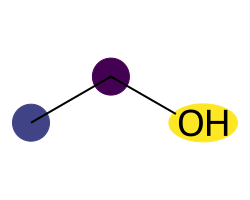


True target: -2.5400
Attribution scores shape: torch.Size([26, 10])


In [115]:
import matplotlib.pyplot as plt

# Run attribution
sample_index = 0
attribution_scores, sample_batch, sample_target, num_nodes = get_node_attribution_gnn(
    model=model_gnn, data_loader=test_loader, sample_index=sample_index
)

smiles = "CCO"  # Make sure this matches the molecule's atom count

# Convert attribution_scores to a 1D NumPy array of Python floats
def prepare_scores(scores):
    arr = scores.detach().cpu().numpy().flatten()
    return [float(x) for x in arr]

attribution_scores_clean = prepare_scores(attribution_scores)
attribution_scores_trimmed = attribution_scores_clean[:3]

# Visualize result
visualize_attribution(smiles, attribution_scores_trimmed, f"Molecule #{sample_index}", 'viridis')

# 6. Print info
print(f"\nTrue target: {sample_target.item():.4f}")
print(f"Attribution scores shape: {attribution_scores.shape}")

## Attribution critique [.75 pt]

**Exercise: Critically evaluate the gradient-based node attribution technique.**

**Goal:** Reflect on the strengths and limitations of the implemented gradient-based attribution method. Consider the following questions in your critique:

*   What kind of insights can you gain from this technique?
*   What aspects of the model's decision-making does this technique *not* reveal?
*   How would you interpret the generated attribution maps in the context of molecular solubility?
*   What are potential weaknesses or biases of this gradient-based approach?
*   Does this technique utilize all available information in the graph structure?
*   What are some potential failure modes or scenarios where this attribution method might be misleading?

**Expected output:** A written critique discussing the interpretation, strengths, limitations, and potential failure modes of the gradient-based node attribution technique for GNNs.


The gradient-based node attribution method helps us understand which atoms in a molecule influenced the model’s prediction the most. This result is useful for understanding the parts of the molecule analyzed by the model and how the model relates structure to properties like solubility. However, it doesn’t show how atoms interact with each other or how bonds affect the prediction, which is important in chemistry. It also might miss important patterns if the model is too complex or if the gradients are small. Sometimes the results can be noisy or misleading, especially for larger molecules or if the model has learned the wrong things. Overall, it’s a helpful tool, but it doesn’t tell the whole story and should be used carefully alongside other methods.